In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

##  make dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

(8100, 30, 1)


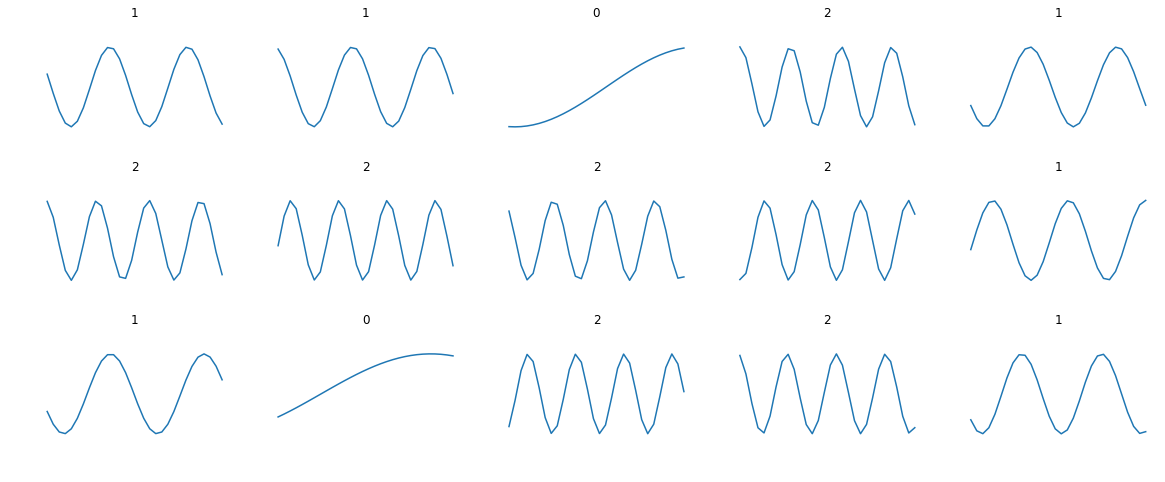

In [3]:
samples = 3000
sequence = 30

def make_sin(T, noise=False, ampl=0.1, freq=1.0):
    x = np.arange(-np.pi * 2, np.pi * 2, 0.25)
    start_seq = np.random.randint(0, x.shape[0] - T, 1)[0]
    sin = np.sin(x[start_seq: start_seq + T] * freq) * 0.5
    noise_ = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(sin))
    return sin + noise_ if noise else sin

# generate training dataset
sin_x = []
sin_y = []
# make different sin_wave by label
for y, freq in enumerate([0.3, 1.5, 3.0]):
    for _ in range(samples):
        ampl = np.random.uniform(low=0.01, high=0.1)
        freq = np.random.uniform(low=freq-0.01, high=freq+0.01)
        sin_x.append(make_sin(sequence, noise=False, ampl=ampl, freq=freq))
        sin_y.append(y)
sin_x = np.array(sin_x).reshape(samples * 3, sequence, 1)
sin_y = np.array(sin_y)

sin_samples = 15
idxes = np.random.randint(0, sin_x.shape[0], sin_samples)
plt.figure(figsize=(20, 8))
# show sin wave
for i in range(sin_samples):
    plt.subplot(3, sin_samples / 3, i + 1)
    plt.plot(sin_x[idxes[i]].squeeze())
    plt.ylim(-0.8, 0.8)
    plt.title(sin_y[idxes[i]])
    plt.axis('off')
    
X_train, X_eval, y_train, y_eval = train_test_split(sin_x,
                                                    sin_y,
                                                    test_size=0.1,
                                                    random_state=1234)

print(X_train.shape)

In [4]:
def sin_plot(sin_sample, c_sample):
    plt.figure(figsize=(8, 1.5))
    for i in range(sin_sample.shape[0]):
        plt.subplot(1, 8, i + 1)
        plt.axis('off')
        plt.plot(sin_sample[i])
        plt.title(c_sample[i])
        plt.ylim(-1.0, 1.0)
    plt.show()

## MMD setting

In [5]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
from mmd import tf_initialize, sigma_optimization

Using TensorFlow backend.


In [6]:
class MMD():
    def __init__(self,
                 seq_length,
                 input_dim,
                 latent_dim):
        self.seq_length = seq_length
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.sigma = 0
        self.dic_tf_sigma = None
        self.that = 0
        self.sess = None

    def set_sigma(self, x_eval):
        self.sigma, self.dic_tf_sigma, self.that, self.sess = tf_initialize(
            x_eval,
            self.seq_length,
            self.input_dim)

    def calc_mmd(self, eval_real, eval_gen):
        eval_real = np.float32(eval_real)
        eval_gen = np.float32(eval_gen)
        # get MMD
        mmd2, that_np = sigma_optimization(eval_real,
                                           eval_gen,
                                           self.sigma,
                                           self.dic_tf_sigma,
                                           self.that,
                                           self.sess)
        return mmd2, that_np

## build RCGAN model

In [7]:
def DPSGD(sigma, l2norm_bound, learning_rate, total_examples):
    import tensorflow as tf
    from differential_privacy.dp_sgd.dp_optimizer import dp_optimizer
    from differential_privacy.dp_sgd.dp_optimizer import sanitizer
    from differential_privacy.privacy_accountant.tf import accountant

    eps = tf.placeholder(tf.float32)
    delta = tf.placeholder(tf.float32)

    priv_accountant = accountant.GaussianMomentsAccountant(total_examples)
    clip = True
    batches_per_lot = 1

    gaussian_sanitizer = sanitizer.AmortizedGaussianSanitizer(
                    priv_accountant,
                    [l2norm_bound, clip])

    return dp_optimizer.DPGradientDescentOptimizer(learning_rate,
                                                  [eps, delta],
                                                  sanitizer=gaussian_sanitizer,
                                                  sigma=sigma,
                                                  batches_per_lot=batches_per_lot)

In [8]:
class RCGAN():
    def __init__(self,
                 input_dim,
                 seq_length,
                 latent_dim,
                 hidden_dim,
                 embed_dim,
                 batch_size,
                 num_classes,
                 summary=False,
                 save_image=False,
                 save_model=False,
                 make_data=False):

        self.input_dim = input_dim
        self.seq_length = seq_length
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.embed_dim = embed_dim
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.save_image = save_image
        self.save_model = save_model
        self.make_data = make_data

        # model instantiation
        self.discriminator = self.build_discriminator()
        self.generator = self.build_generator()
        
        # initialize MMD Class
        self.my_mmd = MMD(self.seq_length, self.input_dim, self.latent_dim)
        
        # define input tenor shape
        # we define batch size here for DP-SGD
        x = Input(batch_shape=(self.batch_size, self.seq_length, self.input_dim))
        z = Input(batch_shape=(self.batch_size, self.seq_length, self.latent_dim))
        c = Input(batch_shape=(self.batch_size, 1), dtype='int32')
        
        self.set_trainable(self.generator, trainable=False)
        
        # discriminator takes real x and gererated gx
        d_logit_real = self.discriminator([x, c])
        gx = self.generator([z, c])
        d_logit_fake = self.discriminator([gx, c])
        
        # get loss function
        d_loss, g_loss = self.gan_loss(d_logit_real, d_logit_fake)
        
        # build traiable discriminator model
        self.D_model = Model([x, z, c], [d_logit_real, d_logit_fake])
        self.D_model.add_loss(d_loss)
        self.D_model.compile(optimizer=D_OPTIMIZER, loss=None)
        
        # freeze discriminator parameter when training discriminator
        self.set_trainable(self.generator, trainable=True)
        self.set_trainable(self.discriminator, trainable=False)
        
        # build traiable generator model
        self.G_model = Model([z, c], d_logit_fake)
        self.G_model.add_loss(g_loss)
        self.G_model.compile(optimizer=G_OPTIMIZER, loss=None)
        
    def gan_loss(self, d_logit_real, d_logit_fake):
        """
        define loss function
        """
        
        d_loss_real = K.mean(K.binary_crossentropy(output=d_logit_real, 
                                                   target=K.ones_like(d_logit_real), 
                                                   from_logits=True))
        d_loss_fake = K.mean(K.binary_crossentropy(output=d_logit_fake, 
                                                   target=K.zeros_like(d_logit_fake), 
                                                   from_logits=True))
        
        d_loss = d_loss_real + d_loss_fake
        
        g_loss = K.mean(K.binary_crossentropy(output=d_logit_fake, 
                                              target=K.ones_like(d_logit_fake), 
                                              from_logits=True))
        
        return d_loss, g_loss
        

    def build_generator(self):

        # define sequential model
        model = Sequential()

        model.add(CuDNNLSTM(units=self.hidden_dim, 
                       return_sequences=True))
        model.add(TimeDistributed(Dense(input_dim, activation='tanh')))

        # define tenor variable
        z = Input(batch_shape=(self.batch_size, self.seq_length, self.latent_dim))
        c = Input(batch_shape=(self.batch_size, 1), dtype='int32')
        c_emb = Flatten()(Embedding(self.num_classes, self.embed_dim)(c))
        c_emb = RepeatVector(self.seq_length)(c_emb)
#         inputs = multiply([z, c_emb])
        inputs = concatenate([z, c_emb], axis=-1)

        # define generator output
        gx = model(inputs)

        return Model([z, c], gx)

    def build_discriminator(self):

        # define sequential model
        model = Sequential()

        model.add(CuDNNLSTM(units=self.hidden_dim, 
                       return_sequences=True))
#         model.add(TimeDistributed(Dense(1, activation='sigmoid')))  pass logit value to loss function
        model.add(TimeDistributed(Dense(1)))

        # define tenor variable 
        x = Input(batch_shape=(self.batch_size, self.seq_length, 1))
        c = Input(batch_shape=(self.batch_size, 1), dtype='int32')
        c_emb = Flatten()(Embedding(self.num_classes, self.embed_dim)(c))
        c_emb = RepeatVector(self.seq_length)(c_emb)
        
#         inputs = multiply([x, c_emb])
        inputs = concatenate([x, c_emb], axis=-1)
    
        # define discriminator output
        validity = model(inputs)

        return Model([x, c], validity)

    def set_trainable(self, model, trainable=False):
        model.trainable = trainable
        for layer in model.layers:
            layer.trainable = trainable
        
    def data_shuffle(self, x, y):
        # shuffle x and y 
        rnd = np.random.randint(999)
        for l in [x, y]:
            np.random.seed(rnd)
            np.random.shuffle(l)

    def train(self, n_epochs, X_train, y_train, X_eval, y_eval):
        
        eval_iter = 10
        self.my_mmd.set_sigma(X_eval[:eval_iter * self.batch_size])

        for epoch in range(n_epochs):

            self.data_shuffle(X_train, y_train)

            for i in range(int(X_train.shape[0] / self.batch_size)):
                
                tr_x = X_train[i * self.batch_size: (i + 1) * self.batch_size]
                tr_y = y_train[i * self.batch_size: (i + 1) * self.batch_size]

                noise = np.random.normal(0, 1, (
                    self.batch_size, self.seq_length, self.latent_dim))

                d_loss_curr = self.D_model.train_on_batch([tr_x, noise, tr_y], None)
                g_loss_curr = self.G_model.train_on_batch([noise, tr_y], None)
            
            if (epoch + 1)% 5 == 0:
                
                # prepare data for maximum mean discrepancy                
                np.random.shuffle(X_eval)
                
                eval_x = []
                eval_gx = []
                for j in range(eval_iter):
                    
                    eval_x.extend(X_eval[j * self.batch_size: (j + 1) * self.batch_size])
                    
                    noise = np.random.normal(0, 1, (
                        self.batch_size, self.seq_length, self.latent_dim))
                    sample_c = np.random.randint(0, self.num_classes,
                                                 self.batch_size)
                    sample_gx = self.generator.predict([noise, sample_c])
                    eval_gx.extend(sample_gx)
                    
                print(len(eval_x))
                    
                mmd2, that_np = self.my_mmd.calc_mmd(eval_x, eval_gx)
                
                # Plot the progress
                print ("epoch {} [D loss: {:.3f}] [G loss: {:.3f}] [MMD2: {:.3f}]".format(epoch + 1,
                                                                           np.mean(d_loss_curr),
                                                                           np.mean(g_loss_curr),
                                                                           0))
                # Plot gererated samples from cureent generator
                sin_plot(sample_gx[:8], sample_c[:8])

## set hyper parameter

In [9]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, CuDNNLSTM
from keras.layers import concatenate, Flatten, Embedding, RepeatVector
from keras.layers.recurrent import LSTM
from keras.models import Sequential, Model
from keras.optimizers import RMSprop, Adam, SGD
from keras.layers.wrappers import TimeDistributed
from keras import backend as K

In [10]:
# from keras.backend.tensorflow_backend import set_session
# import tensorflow as tf

# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.Session(config=config)
# set_session(sess)

In [11]:
# hyper parameter for training

sigma = 100.0
l2norm_bound = 1e-04
learning_rate = 0.1
total_examples = X_train.shape[0]

input_dim = X_train.shape[2]
seq_length = X_train.shape[1]
latent_dim = 50
hidden_dim = 100
embed_dim = 10
batch_size = 32
n_epochs = 50
num_classes = 3

D_OPTIMIZER = DPSGD(sigma, l2norm_bound, learning_rate, total_examples)
# D_OPTIMIZER = SGD(0.1)
G_OPTIMIZER = Adam()

rcgan = RCGAN(input_dim,
              seq_length,
              latent_dim,
              hidden_dim,
              embed_dim,
              batch_size,
              num_classes)

## train iteration

In [12]:
%%time
rcgan.train(n_epochs, X_train, y_train, X_eval, y_eval)

InternalError: Failed to create session.

## reconstruction

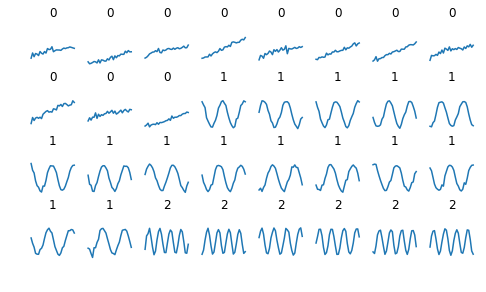

In [12]:
def sin_plot(sin_sample, c_sample):
    plt.figure(figsize=(8, 4.5))
    for i in range(sin_sample.shape[0]):
        plt.subplot(4, 8, i + 1)
        plt.axis('off')
        plt.plot(sin_sample[i])
        plt.title(c_sample[i])
        plt.ylim(-1.0, 1.0)
    plt.show()

noise = np.random.normal(0, 1, (batch_size, seq_length, latent_dim))
sample_c = np.sort(np.random.randint(0, num_classes, batch_size))
sample_gx = rcgan.generator.predict([noise, sample_c])
sin_plot(sample_gx, sample_c)

In [12]:
# hyper parameter for training
input_dim = X_train.shape[2]
seq_length = X_train.shape[1]
latent_dim = 50
hidden_dim = 100
embed_dim = 10
batch_size = 32
n_epochs = 50
num_classes = 3

sigma = 2.0
D_OPTIMIZER = DPSGD(sigma, l2norm_bound, learning_rate, total_examples)
# D_OPTIMIZER = SGD(0.1)
G_OPTIMIZER = Adam()

rcgan = RCGAN(input_dim,
              seq_length,
              latent_dim,
              hidden_dim,
              embed_dim,
              batch_size,
              num_classes)

epoch 5 [D loss: 1.374] [G loss: 0.346] [MMD2: 0.027]


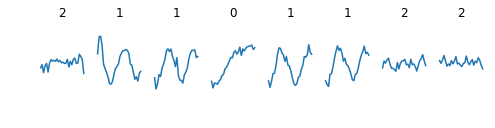

epoch 10 [D loss: 1.400] [G loss: 0.760] [MMD2: 0.020]


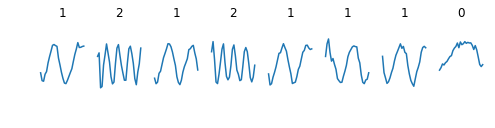

epoch 15 [D loss: 1.392] [G loss: 0.971] [MMD2: 0.019]


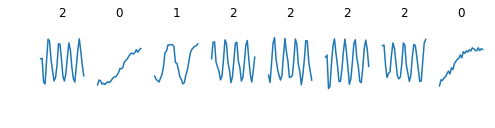

epoch 20 [D loss: 1.385] [G loss: 0.763] [MMD2: 0.019]


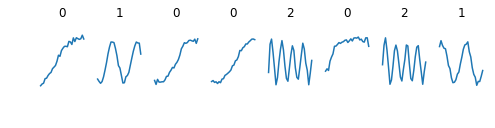

epoch 25 [D loss: 1.337] [G loss: 0.955] [MMD2: 0.019]


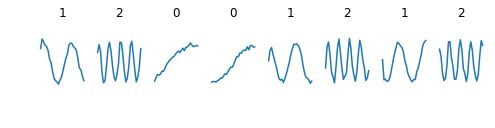

epoch 30 [D loss: 1.379] [G loss: 0.688] [MMD2: 0.012]


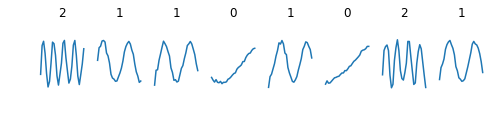

epoch 35 [D loss: 1.254] [G loss: 0.915] [MMD2: 0.009]


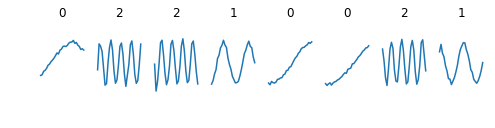

epoch 40 [D loss: 1.172] [G loss: 1.244] [MMD2: 0.010]


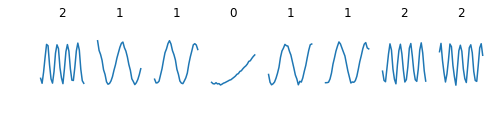

epoch 45 [D loss: 1.316] [G loss: 1.122] [MMD2: 0.009]


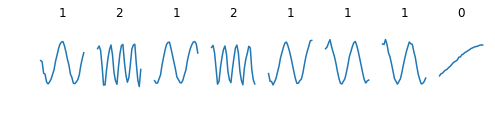

epoch 50 [D loss: 1.289] [G loss: 0.790] [MMD2: 0.008]


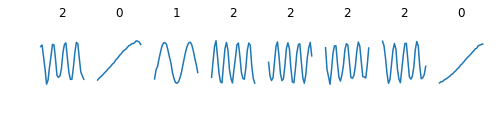

CPU times: user 16min 56s, sys: 6min 9s, total: 23min 6s
Wall time: 6min 58s


In [13]:
%%time
rcgan.train(n_epochs, X_train, y_train, X_eval, y_eval)